In [14]:
import numpy as np
# from tqdm import tdqm, trange

import torch
import torch.nn as nn
from torch.optim import Adam,lr_scheduler
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

import os
from PIL import Image

from tqdm import tqdm, trange
import torch

import torchvision.transforms as transforms



np.random.seed(0)
torch.manual_seed(0)
print(torch.backends.mps.is_available())
mps_device = torch.device("mps")
print(mps_device)

True
mps


In [15]:
import PIL
from PIL import Image
import numpy as np
import os
import random 
import pandas as pd
# open method used to open different extension image file
TRAIN_DATA_FOLDER = "../datasets/MRI/data/mri_data_full/train"
train_tumor_filenames = os.listdir(f'{TRAIN_DATA_FOLDER}/tumor/')
num_train_tumor_files = len(train_tumor_filenames)
print("Number of Training Tumor Files: ", num_train_tumor_files)

train_notumor_filenames = os.listdir(f'{TRAIN_DATA_FOLDER}/notumor/')
num_train_notumor_files = len(train_notumor_filenames)
print("Number of Training No Tumor Files: ", num_train_notumor_files)

Number of Training Tumor Files:  1339
Number of Training No Tumor Files:  1595


## Transformer Model Architecture
![Transformer Model](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*tA7xE2dQA_dfzA0Bub5TVw.png)

## Resizing Image

### Formula [e.g (N,1,28,28)] 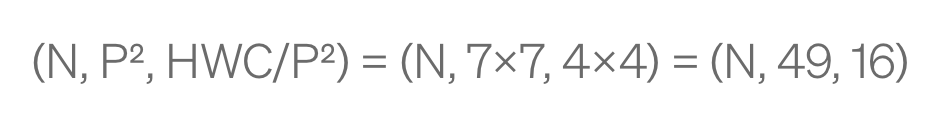
![Reshaping Image](https://miro.medium.com/v2/resize:fit:822/format:webp/1*CFbOxEuvo-Pgq7ETIrt0Eg.png)


### Positional Embedding
![Positional Embedding Formula](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*lpRYHE0XjVkxRVKFrWkzuw.png)

In [16]:
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

def main():

    IMAGE_SIZE = (1,128,128)
    NUM_PATCHES = 32

    train_dataset = MRIDataset('../datasets/MRI/data/train/', transform=ToTensor(),image_shape = IMAGE_SIZE[1])
    train_loader  = DataLoader(train_dataset, shuffle=True, batch_size=128)

    test_dataset = MRIDataset('../datasets/MRI/test/', transform=ToTensor(),image_shape = IMAGE_SIZE[1])
    test_loader  = DataLoader(test_dataset, shuffle=False, batch_size=128)

    # Get one batch (single image and label)
    for images, labels in train_loader:
        # Extract the first image and label
        image = images[0]  # Tensor shape: (C, H, W)
        label = labels[0]
        
        if label == 1:
            # Convert the tensor back to a PIL image for display
            to_pil = ToPILImage()
            image_pil = to_pil(image)

            # Display the image
            plt.imshow(image_pil)
            plt.title(f"Label: {label}")
            plt.axis('off')
            plt.show()
            break

    for images, labels in train_loader:
        # Extract the first image and label
        image = images[0]  # Tensor shape: (C, H, W)
        label = labels[0]

        if label == 0:
            # Convert the tensor back to a PIL image for display
            to_pil = ToPILImage()
            image_pil = to_pil(image)

            # Display the image
            plt.imshow(image_pil)
            plt.title(f"Label: {label}")
            plt.axis('off')
            plt.show()
            break

    print(train_loader)
    device = torch.device("cuda" if torch.cuda.is_available() else "mps")
    # print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available else "")
    model = MyViT(IMAGE_SIZE, n_patches=NUM_PATCHES, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)

    N_EPOCHS = 5
    LR = 0.005
    
    # Training Loop
    optimizer = Adam(model.parameters(),lr = LR)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS,desc="Training"):
        train_loss = 0.0
        for batch in tqdm(train_loader,desc=f"Epoch{epoch+1} in training", leave=False):
            x,y = batch
            # print(y.shape)
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat,y)
            train_loss += loss.detach().cpu().item()/len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()
        print(f"Epoch {epoch+1}/{N_EPOCHS} loss: {train_loss:.2f}")

    with torch.no_grad():
        correct,total = 0,0
        test_loss = 0.0
        for batch in tqdm(test_loader,desc="Testing"):
            x,y = batch
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat,y)
            test_loss += loss.detach().cpu().item()/len(test_loader)

            correct += torch.sum(torch.argmax(y_hat,dim=1) == y).detach().cpu()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")




# Multi-Self Attention Class

In [17]:
from MyViT.ViT import * 
from MyViT.utils import MRIDataset,get_positional_embeddings,patchify

if __name__ == '__main__':
    main()

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/MRI/test/tumor'

# Causal AI Implementation


Observing Causal Variational Encoder Behavior


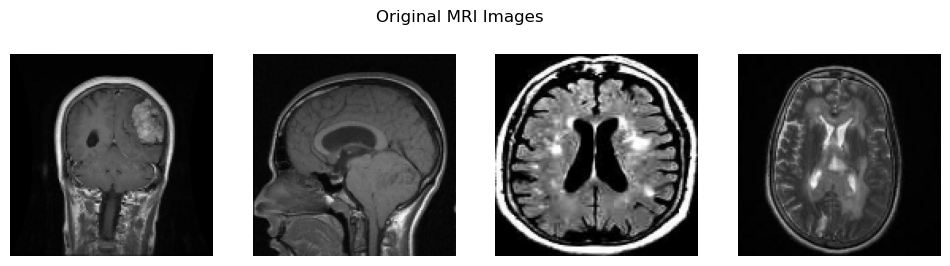

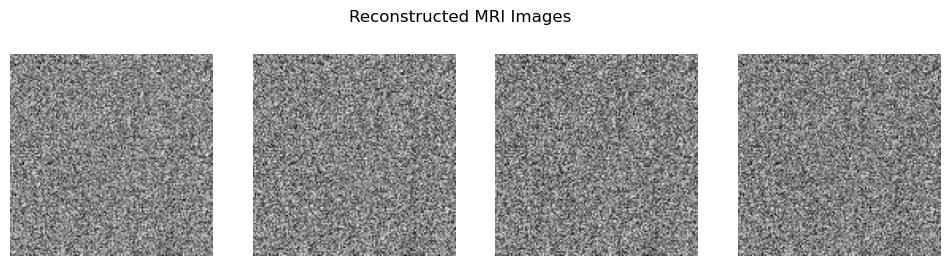

In [21]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from CausalVAE.causal_vae import CausalVAE
from MyViT.utils import MRIDataset  # Assuming MRIDataset is defined in your utils.py

# Assume IMAGE_SIZE is defined somewhere in your code; for example:
# IMAGE_SIZE = (1, 224, 224)  -> grayscale image with height and width of 224 pixels
image_size = 128  # You can set this based on IMAGE_SIZE[1]
input_dim = image_size * image_size  # For grayscale images

# Define the dimensions for the causal VAE
z_dim = 50
hidden_dim = 100

# Instantiate the causal VAE model
model = CausalVAE(input_dim=input_dim, z_dim=z_dim, hidden_dim=hidden_dim)
model.eval()  # Set the model to evaluation mode

# Load your MRI dataset using MRIDataset from utils.py
train_dataset = MRIDataset('../datasets/MRI/data/train/', transform=ToTensor(), image_shape=image_size)
train_loader  = DataLoader(train_dataset, shuffle=True, batch_size=128)

# Get a random batch from the train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Assuming images are of shape (batch_size, channels, height, width)
# If the images are grayscale, channels=1; we flatten the images for the VAE
batch_size = images.size(0)
images_flat = images.view(batch_size, -1)  # shape: (batch_size, input_dim)

# Pass the images through the causal VAE to obtain reconstructions and latent variables
with torch.no_grad():
    reconstructions, z, z_mu, z_logvar = model(images_flat)

# Helper function to display images
def show_images(imgs, title, image_shape=(image_size, image_size), n=4):
    # Only use the first n images
    imgs = imgs[:n]
    imgs = imgs.view(-1, *image_shape).cpu()
    batch = imgs.size(0)
    fig, axes = plt.subplots(1, batch, figsize=(3 * batch, 3))
    for i in range(batch):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

# Visualize the original and reconstructed images
show_images(images_flat, "Original MRI Images", image_shape=(image_size, image_size))
show_images(reconstructions, "Reconstructed MRI Images", image_shape=(image_size, image_size))